In [1]:
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import scienceplots

# Prueba con XGBoost

## Función de Bootstrapping para analizar los mejores individuos

In [58]:
def bootstrap_confidence_intervals_df(df, param_cols, fitness_col='fitness', n_bootstrap=1000, alpha=0.05):
    """
    Calcula intervalos de confianza para:
    - la media de los parámetros
    - los parámetros del mejor individuo (fitness mínimo)
    Además imprime las medias bootstrapped.
    """

    # Convertimos a cupy
    poblacion_params = cp.asarray(df[param_cols].values)
    poblacion_fitness = cp.asarray(df[fitness_col].values)

    N, d = poblacion_params.shape
    mean_params_samples = cp.zeros((n_bootstrap, d))
    best_params_samples = cp.zeros((n_bootstrap, d))

    rng = cp.random.default_rng()

    for i in range(n_bootstrap):
        idx = rng.integers(0, N, size=N)
        sample_params = poblacion_params[idx]
        sample_fitness = poblacion_fitness[idx]

        # media de parámetros
        mean_params_samples[i] = sample_params.mean(axis=0)

        # mejores parámetros
        best_idx = cp.argmin(sample_fitness)
        best_params_samples[i] = sample_params[best_idx]

    low_q = 100 * (alpha/2)
    high_q = 100 * (1 - alpha/2)

    mean_params_CI = cp.percentile(mean_params_samples, [low_q, high_q], axis=0)
    best_params_CI = cp.percentile(best_params_samples, [low_q, high_q], axis=0)

    # >>> NUEVO: medias bootstrapped
    mean_params_boot_mean = mean_params_samples.mean(axis=0).get()
    best_params_boot_mean = best_params_samples.mean(axis=0).get()

    mean_df = pd.DataFrame({
        "param": param_cols,
        "low": mean_params_CI[0].get(),
        "high": mean_params_CI[1].get(),
        "boot_mean": mean_params_boot_mean
    })

    best_df = pd.DataFrame({
        "param": param_cols,
        "low": best_params_CI[0].get(),
        "high": best_params_CI[1].get(),
        "boot_mean": best_params_boot_mean
    })

    return {"mean_params_CI": mean_df, "best_params_CI": best_df}

## Experimento 1

In [71]:
# ---------------------------
# 1. Cargar datos
# ---------------------------

# Ruta de la carpeta con los CSV
ruta_exp1 = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/Genetico/resultados/exp1-v2"

# Buscar todos los archivos CSV en la carpeta
archivos_csv_exp1 = glob.glob(os.path.join(ruta_exp1, "*.csv"))

# Leer y concatenar
df_exp1 = pd.concat((pd.read_csv(archivo) for archivo in archivos_csv_exp1), ignore_index=True)

# Features y target
X_exp1 = df_exp1[["D", "A", "B", "x", "y"]] 
y_exp1 = df_exp1["fitness"]

df_exp1.head()

# ---------------------------
# 2. Train / Test split
# ---------------------------
X_train_exp1, X_test_exp1, y_train_exp1, y_test_exp1 = train_test_split(
    X_exp1, y_exp1, test_size=0.2, random_state=42
)

# ---------------------------
# 3. Entrenar modelo XGBoost
# ---------------------------
model_exp1 = xgb.XGBRegressor(
    n_estimators=5500,
    learning_rate=0.009,
    max_depth=11,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    tree_method="hist",   # GPU
    device="cuda",
    random_state=42
)

model_exp1.fit(X_train_exp1, y_train_exp1)

# ---------------------------
# 4. Evaluar surrogate
# ---------------------------
y_pred_exp1 = model_exp1.predict(X_test_exp1)

mse_exp1 = mean_squared_error(y_test_exp1, y_pred_exp1)
r2_exp1 = r2_score(y_test_exp1, y_pred_exp1)

print(f"MSE: {mse_exp1:.6f}")
print(f"R²: {r2_exp1:.6f}")

MSE: 0.000702
R²: 0.994244


In [30]:
from sklearn.model_selection import cross_val_score, KFold

# Definir la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar R²
r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
mse_scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")

print("R² promedio:", np.mean(r2_scores), "+/-", np.std(r2_scores))
print("MSE promedio:", -np.mean(mse_scores), "+/-", np.std(mse_scores))

R² promedio: 0.9974611518811349 +/- 4.1467593999821946e-05
MSE promedio: 0.00011401502901372409 +/- 2.1739398220891764e-06


C:\Users\becer\AppData\Local\Temp\ipykernel_53440\3132420794.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
C:\Users\becer\AppData\Local\Temp\ipykernel_53440\3132420794.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


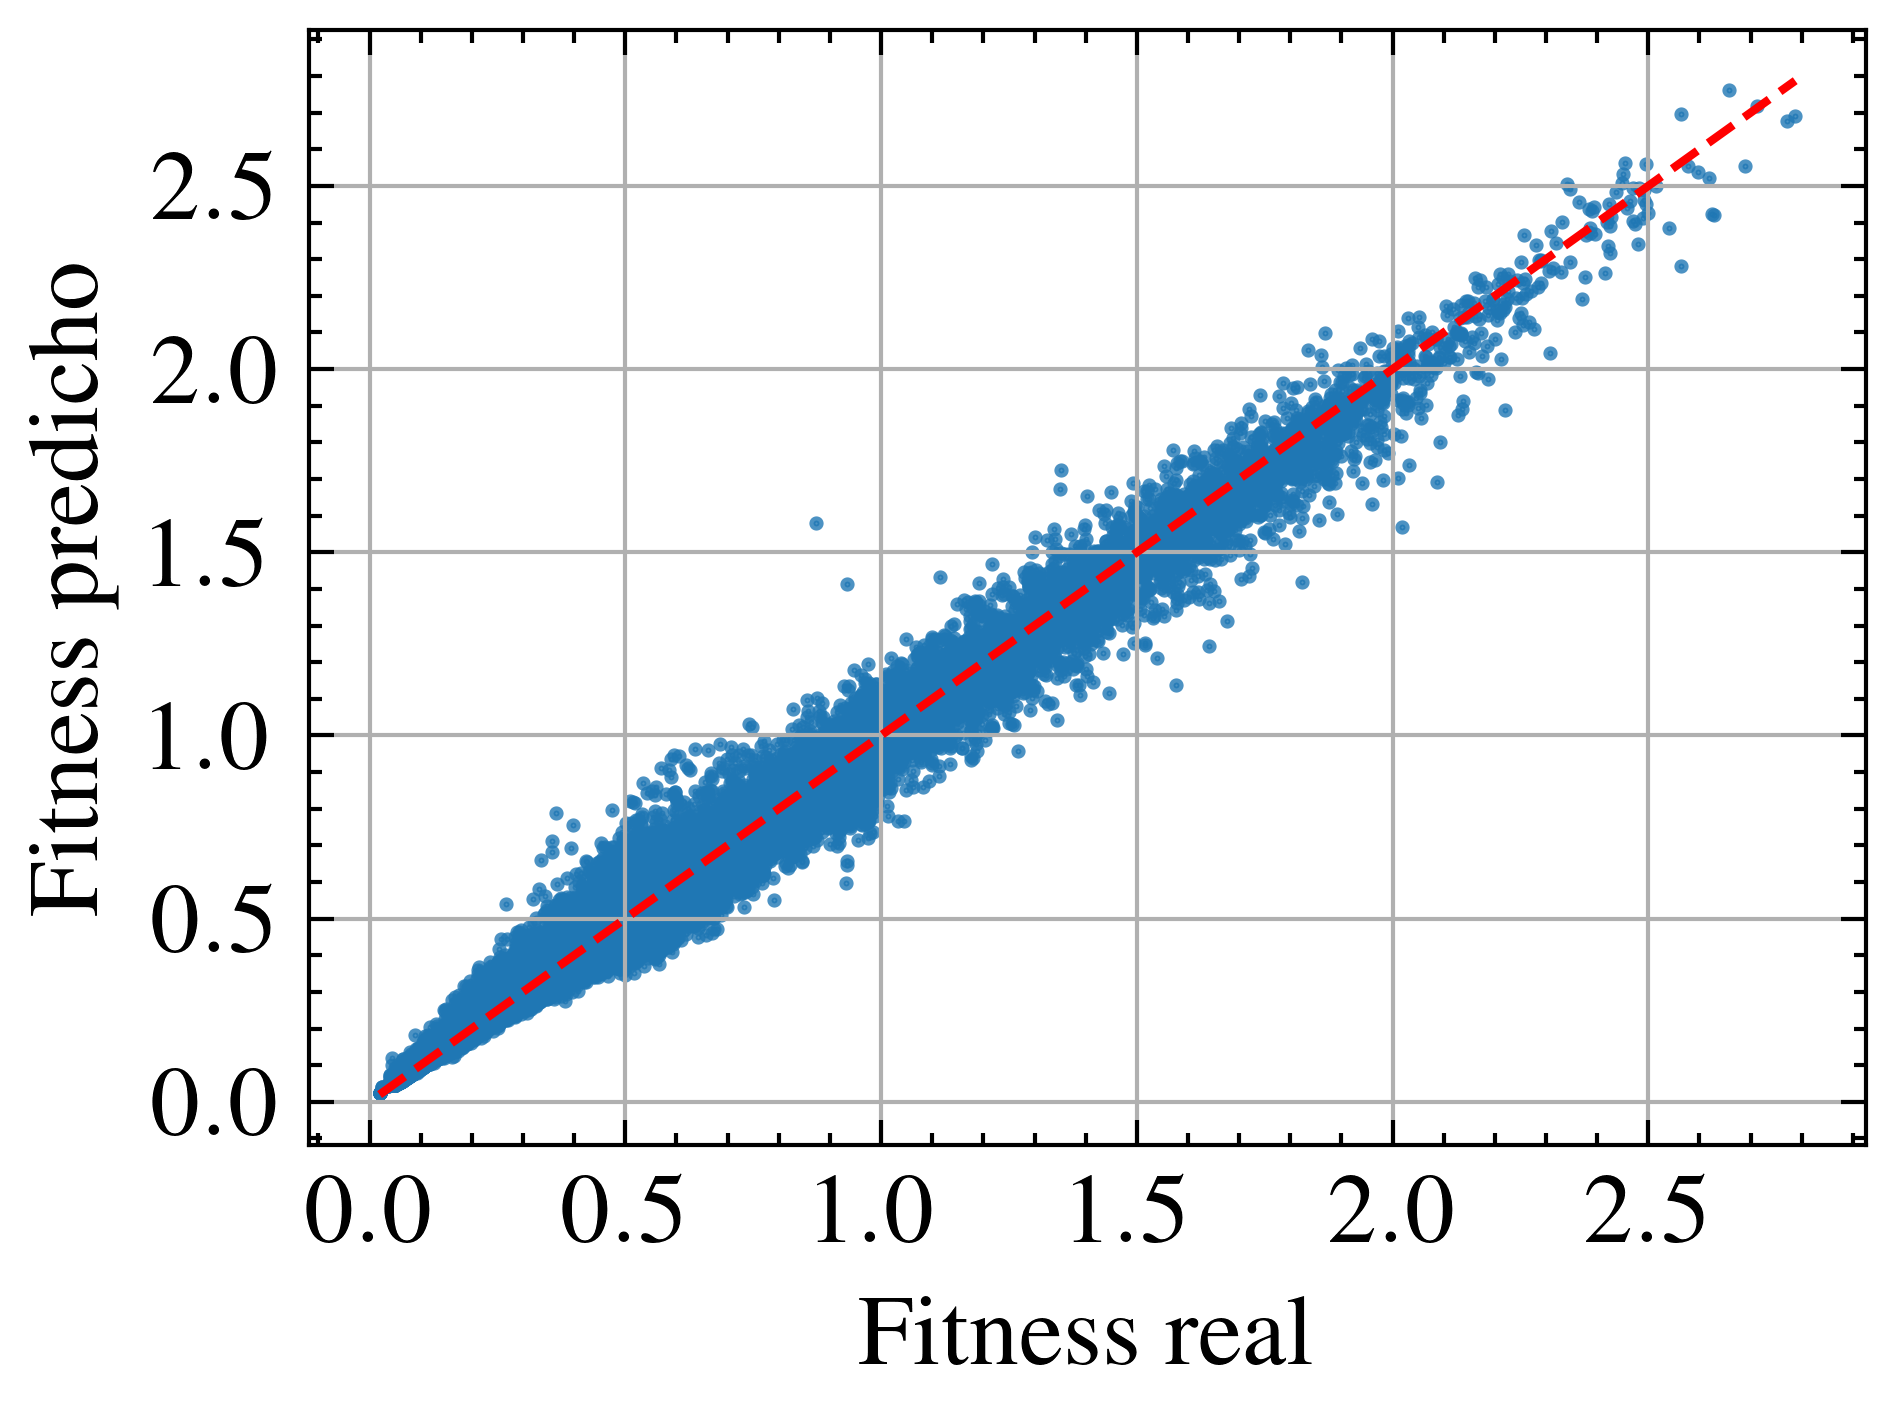

In [73]:
# 5. Visualización: real vs predicho
plt.style.use(["science", "ieee"])  # activás scienceplots
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.tab10.colors)  # ciclo estándar matplotlib

# ---------------------------
fig, ax = plt.subplots()
ax.scatter(y_test_exp1, y_pred_exp1, alpha=0.8, s=0.5)
ax.plot([y_test_exp1.min(), y_test_exp1.max()],
         [y_test_exp1.min(), y_test_exp1.max()],
         'r--')
ax.set_xlabel("Fitness real", fontsize=12)
ax.set_ylabel("Fitness predicho", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.grid()
plt.tight_layout()
plt.savefig("XGBoost_test_exp1.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [75]:
# ---------------------------
# 6. Usar surrogate para explorar
# ---------------------------
# Rango de parámetros según tu dataframe
param_ranges = {
    "D": (df_exp1["D"].min(), df_exp1["D"].max()),
    "A": (df_exp1["A"].min(), df_exp1["A"].max()),
    "B": (df_exp1["B"].min(), df_exp1["B"].max()),
    "x": (df_exp1["x"].min(), df_exp1["x"].max()),
    "y": (df_exp1["y"].min(), df_exp1["y"].max()),
}

# Configuración de la búsqueda
N_total = int(1e8)       # total de candidatos a probar (200 millones)
batch_size = int(1e6)    # tamaño del batch (1 millón)
n_batches = N_total // batch_size

k = 20  # top-k por batch
mejores_globales = []

for i in range(n_batches):
    print(f"Batch {i+1}/{n_batches}")

    # Generar candidatos aleatorios dentro de los rangos
    candidatos = np.column_stack([
        np.random.uniform(low, high, batch_size)
        for (low, high) in param_ranges.values()
    ])

    # Predecir fitness con el surrogate model
    preds = model_exp1.predict(candidatos)

    # Obtener los mejores índices (menor fitness = mejor)
    top_idx = np.argsort(preds)[:k]

    # Guardar pares (parámetros, fitness)
    for idx in top_idx:
        mejores_globales.append((candidatos[idx], preds[idx]))

# Convertir a array y seleccionar los mejores globales
mejores_globales = sorted(mejores_globales, key=lambda x: x[1])[:200]

# Separar parámetros y fitness
candidatos_finales = np.array([x[0] for x in mejores_globales])
fitness_finales = np.array([x[1] for x in mejores_globales])

print("Top candidatos encontrados:")
for i, (params, fit) in enumerate(zip(candidatos_finales, fitness_finales), 1):
    print(f"{i}: {params}, fitness={fit}")

Batch 1/100
Batch 2/100
Batch 3/100
Batch 4/100
Batch 5/100
Batch 6/100
Batch 7/100
Batch 8/100
Batch 9/100
Batch 10/100
Batch 11/100
Batch 12/100
Batch 13/100
Batch 14/100
Batch 15/100
Batch 16/100
Batch 17/100
Batch 18/100
Batch 19/100
Batch 20/100
Batch 21/100
Batch 22/100
Batch 23/100
Batch 24/100
Batch 25/100
Batch 26/100
Batch 27/100
Batch 28/100
Batch 29/100
Batch 30/100
Batch 31/100
Batch 32/100
Batch 33/100
Batch 34/100
Batch 35/100
Batch 36/100
Batch 37/100
Batch 38/100
Batch 39/100
Batch 40/100
Batch 41/100
Batch 42/100
Batch 43/100
Batch 44/100
Batch 45/100
Batch 46/100
Batch 47/100
Batch 48/100
Batch 49/100
Batch 50/100
Batch 51/100
Batch 52/100
Batch 53/100
Batch 54/100
Batch 55/100
Batch 56/100
Batch 57/100
Batch 58/100
Batch 59/100
Batch 60/100
Batch 61/100
Batch 62/100
Batch 63/100
Batch 64/100
Batch 65/100
Batch 66/100
Batch 67/100
Batch 68/100
Batch 69/100
Batch 70/100
Batch 71/100
Batch 72/100
Batch 73/100
Batch 74/100
Batch 75/100
Batch 76/100
Batch 77/100
Batch 78

In [76]:
print(candidatos_finales)
np.savetxt("candidatos_finales_xgboost_exp1.csv", candidatos_finales, delimiter=",", header="D,A,B,x,y", comments='')

[[1.27633096e+01 1.84591762e-04 2.29401611e+01 3.94042825e+02
  6.08226519e+02]
 [1.36952662e+01 1.78864936e-04 2.31202229e+01 3.94826417e+02
  6.08998717e+02]
 [1.17342959e+01 1.81922322e-04 2.14443642e+01 3.95974565e+02
  6.07583422e+02]
 [1.12632293e+01 1.61617119e-04 2.10019272e+01 3.94707445e+02
  6.06141900e+02]
 [1.45770738e+01 1.89637309e-04 2.48478598e+01 3.95073678e+02
  6.09604430e+02]
 [1.36941590e+01 1.56447814e-04 2.31866048e+01 3.97744751e+02
  6.08798276e+02]
 [1.12342097e+01 1.65032860e-04 1.85413409e+01 3.92446629e+02
  6.07590819e+02]
 [1.15685758e+01 1.53270291e-04 1.98300719e+01 3.99024302e+02
  6.07393017e+02]
 [1.43088300e+01 1.69300208e-04 2.23737300e+01 3.97965817e+02
  6.08219690e+02]
 [1.24911847e+01 1.77638958e-04 2.14551700e+01 3.92489584e+02
  6.07894450e+02]
 [1.38447786e+01 1.49914755e-04 2.16592983e+01 3.98211482e+02
  6.08616593e+02]
 [1.44270514e+01 2.02384349e-04 2.58331547e+01 3.93374047e+02
  6.10152453e+02]
 [1.50275005e+01 1.75759246e-04 2.232518

In [15]:
# print(candidatos_finales.mean(axis=0))

model.predict([[10.0, 1e-4, 15, 400, 600]])

array([0.02920109], dtype=float32)

### Validación de los resultados obtenidos con XGBoost

In [77]:
import pandas as pd
from lectura_datos import leer_incendio_referencia
from fitness import aptitud_batch
import cupy as cp

df_candidatos = pd.read_csv("candidatos_finales_xgboost_exp1.csv")
print(df_candidatos)
candidatos = df_candidatos[["D", "A", "B", "x", "y"]].values
    
ruta_incendio_referencia = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/R_referencia_1.npy"
incendio_referencia = leer_incendio_referencia(ruta_incendio_referencia)
celdas_quemadas_referencia = cp.where(incendio_referencia > 0.001, 1, 0)

batch_size = 5

resultados = []

for i in range(0, len(candidatos), batch_size):
    print(f'Evaluando batch {i//batch_size + 1} de {len(candidatos)//batch_size + 1}')
    candidatos_batch = candidatos[i:i+batch_size]
    fitness = aptitud_batch(candidatos_batch, 
                            celdas_quemadas_referencia, 
                            num_steps=500, 
                            ajustar_beta_gamma=False,
                            beta_fijo=[0.91, 0.72, 1.38, 1.94, 0.75], 
                            gamma_fijo=[0.5, 0.38, 0.84, 0.45, 0.14],
                            ajustar_ignicion=True,
                            ignicion_fija_x=None,
                            ignicion_fija_y=None)

    for params, fitness in zip(candidatos_batch, fitness):
        D, A, B, x, y = params
        resultados.append({"D": D, "A": A, "B": B, "x": x, "y": y, "fitness": fitness})
    
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="fitness", ascending=True)

print(df_resultados)
df_resultados.to_csv("candidatos_finales_validados_exp1.csv", index=False)

             D         A          B           x           y
0    12.763310  0.000185  22.940161  394.042825  608.226519
1    13.695266  0.000179  23.120223  394.826417  608.998717
2    11.734296  0.000182  21.444364  395.974565  607.583422
3    11.263229  0.000162  21.001927  394.707445  606.141900
4    14.577074  0.000190  24.847860  395.073678  609.604430
..         ...       ...        ...         ...         ...
195  12.429665  0.000168  18.738565  397.314261  610.694342
196   8.951379  0.000144  17.857614  392.024933  601.538864
197  11.094490  0.000150  18.276920  394.820059  603.082803
198  11.330212  0.000138  24.186220  397.790021  605.177585
199  10.830854  0.000167  25.266082  395.349197  605.505644

[200 rows x 5 columns]
Evaluando batch 1 de 41
Batch size: 5
Numero de pasos a simular: 500
Evaluando batch 2 de 41
Batch size: 5
Numero de pasos a simular: 500
Evaluando batch 3 de 41
Batch size: 5
Numero de pasos a simular: 500
Evaluando batch 4 de 41
Batch size: 5
Numero de p

In [80]:
# Uso
res = bootstrap_confidence_intervals_df(df_resultados, param_cols=["D", "A", "B", "x", "y"])
pd.set_option("display.precision", 10)
best_ci = res["best_params_CI"].copy()

best_ci["uncertainty_%"] = ((best_ci["high"] - best_ci["low"]) / 2) / best_ci["boot_mean"] * 100
print(best_ci.round(7))

  param          low         high    boot_mean  uncertainty_%
0     D    9.8455333   10.3611215   10.2151840      2.5236364
1     A    0.0000884    0.0001400    0.0001000     25.8093502
2     B   12.6219201   18.9098172   13.8014594     22.7798268
3     x  396.1849954  399.4650998  398.9480509      0.4110942
4     y  599.6375303  603.7884912  600.3368204      0.3457193


## Experimento 2

In [ ]:
# ---------------------------
# 1. Cargar datos
# ---------------------------

# Ruta de la carpeta con los CSV
ruta_exp2 = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/Genetico/resultados/exp2-2"

# Buscar todos los archivos CSV en la carpeta
archivos_csv_exp2 = glob.glob(os.path.join(ruta_exp2, "*.csv"))

# Leer y concatenar
df_exp2 = pd.concat((pd.read_csv(archivo) for archivo in archivos_csv_exp2), ignore_index=True)

# Features y target
X_exp2 = df_exp2[["D", "A", "B", "x", "y", "beta", "gamma"]] 
y_exp2 = df_exp2["fitness"]

print(df_exp2.head())

# ---------------------------
# 2. Train / Test split
# ---------------------------
X_train_exp2, X_test_exp2, y_train_exp2, y_test_exp2 = train_test_split(
    X_exp2, y_exp2, test_size=0.2, random_state=42
)

# ---------------------------
# 3. Entrenar modelo XGBoost
# ---------------------------
model_exp2 = xgb.XGBRegressor(
    n_estimators=5500,
    learning_rate=0.009,
    max_depth=11,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    tree_method="hist",   # GPU
    device="cuda",
    random_state=42
)

model_exp2.fit(X_train_exp2, y_train_exp2)

# ---------------------------
# 4. Evaluar surrogate
# ---------------------------
y_pred_exp2 = model_exp2.predict(X_test_exp2)

mse_exp2 = mean_squared_error(y_test_exp2, y_pred_exp2)
r2_exp2 = r2_score(y_test_exp2, y_pred_exp2)

print(f"MSE: {mse_exp2:.6f}")
print(f"R²: {r2_exp2:.6f}")

MSE: 0.000598
R²: 0.982647


In [37]:
from sklearn.model_selection import cross_val_score, KFold

# Definir la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar R²
r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
mse_scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")

print("R² promedio:", np.mean(r2_scores), "+/-", np.std(r2_scores))
print("MSE promedio:", -np.mean(mse_scores), "+/-", np.std(mse_scores))

R² promedio: 0.980836062194799 +/- 0.00013406881285503433
MSE promedio: 0.0008198152163577625 +/- 7.299607409052934e-06


C:\Users\becer\AppData\Local\Temp\ipykernel_53440\1393066467.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
C:\Users\becer\AppData\Local\Temp\ipykernel_53440\1393066467.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


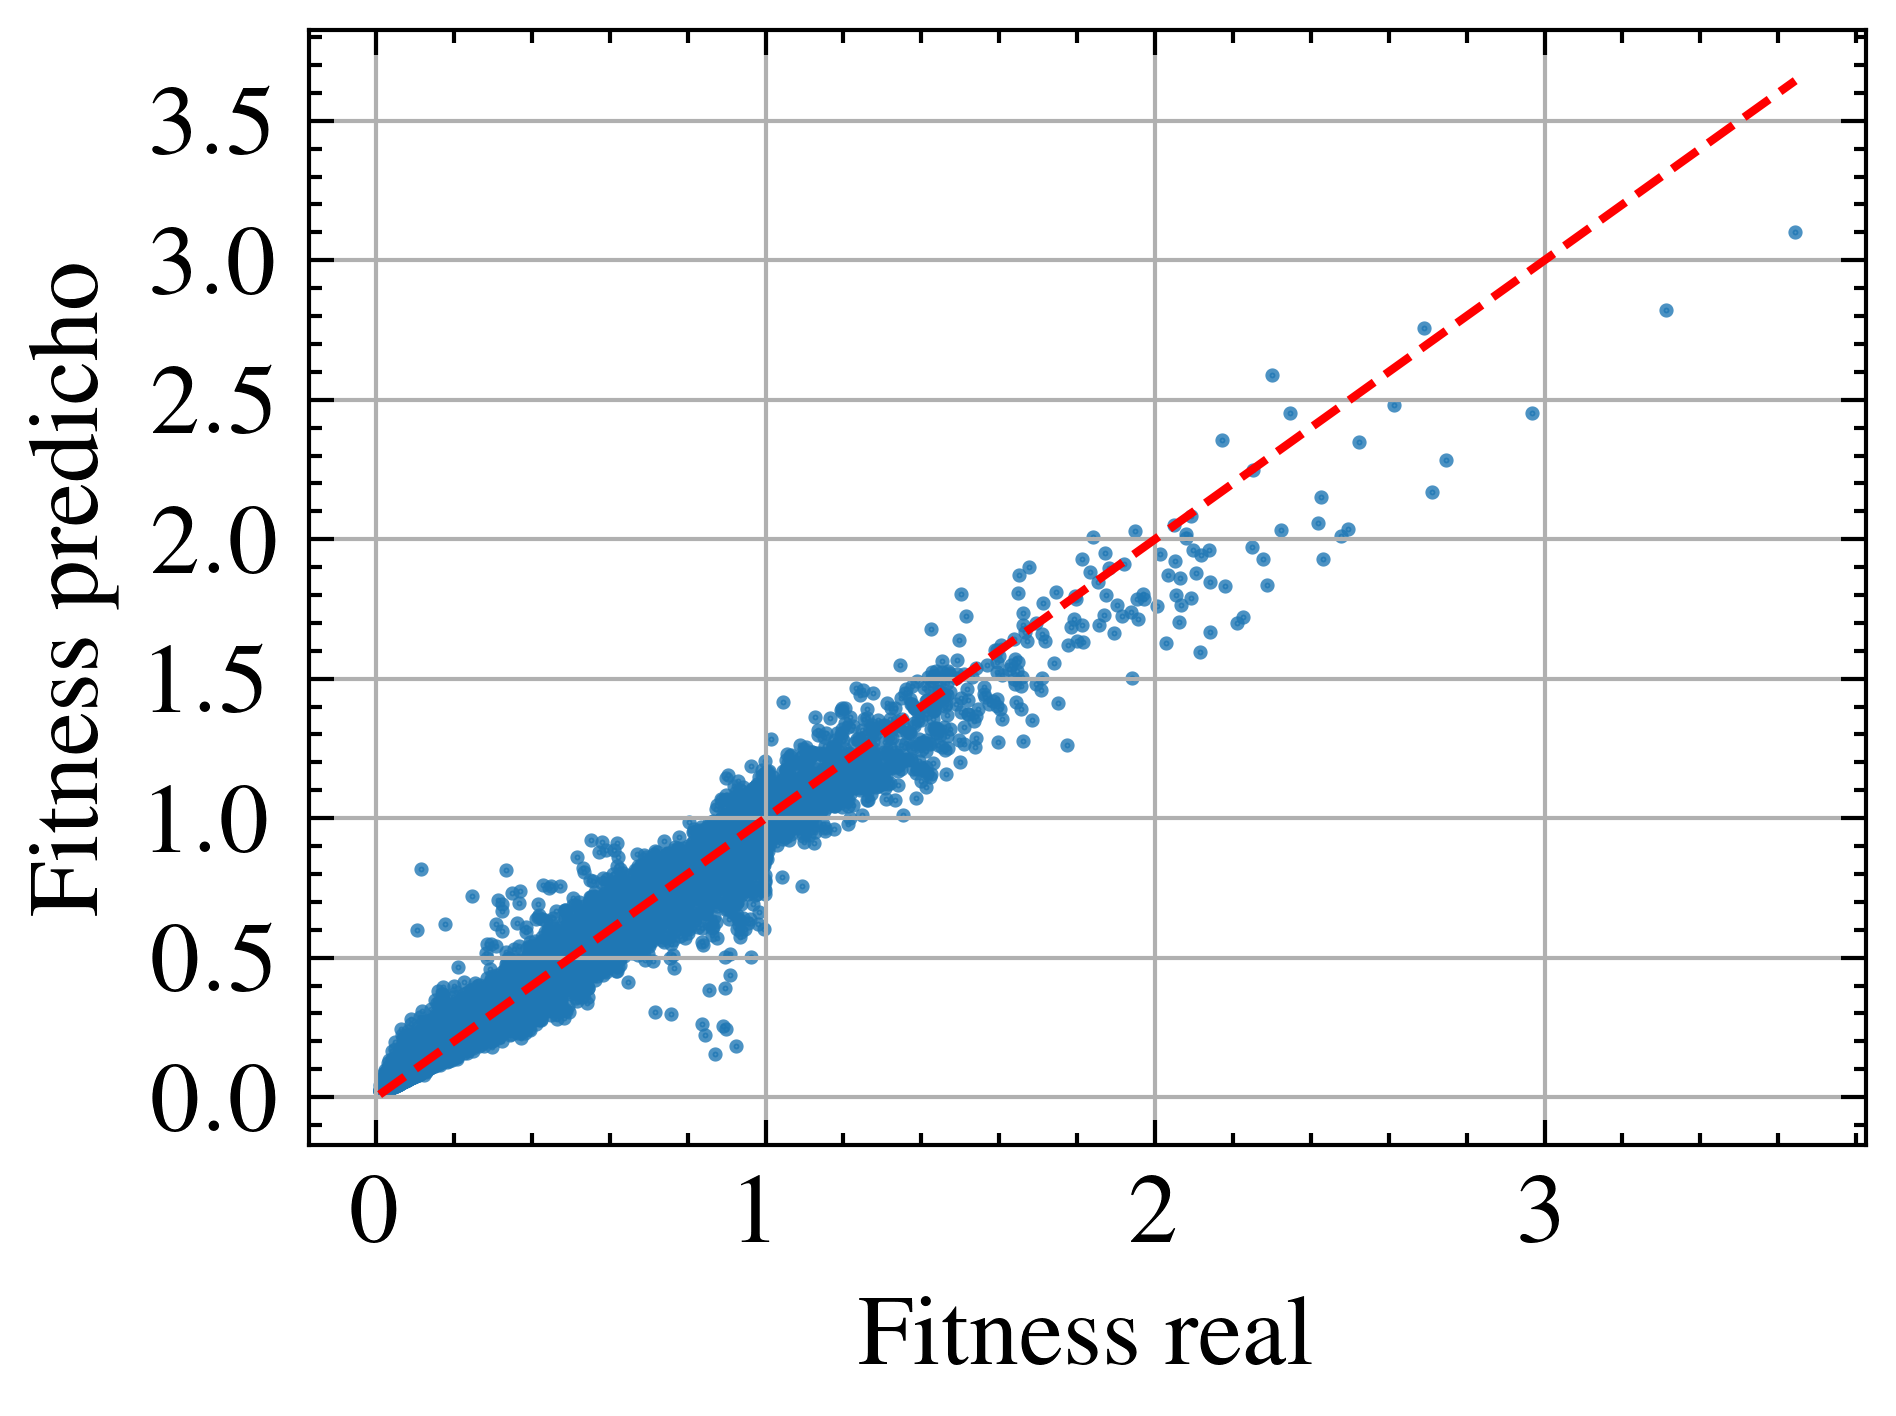

In [62]:
# 5. Visualización: real vs predicho
plt.style.use(["science", "ieee"])  # activás scienceplots
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.tab10.colors)  # ciclo estándar matplotlib

# ---------------------------
fig, ax = plt.subplots()
ax.scatter(y_test_exp2, y_pred_exp2, alpha=0.8, s=0.5)
ax.plot([y_test_exp2.min(), y_test_exp2.max()],
         [y_test_exp2.min(), y_test_exp2.max()],
         'r--')
ax.set_xlabel("Fitness real", fontsize=12)
ax.set_ylabel("Fitness predicho", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
# plt.xlim(0, 0.1)
# plt.ylim(0, 0.1)
plt.grid()
plt.tight_layout()
plt.savefig("XGBoost_test_exp2.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [81]:
# ---------------------------
# 6. Usar surrogate para explorar
# ---------------------------
# Rango de parámetros según tu dataframe
param_ranges = {
    "D": (df_exp2["D"].min(), df_exp2["D"].max()),
    "A": (df_exp2["A"].min(), df_exp2["A"].max()),
    "B": (df_exp2["B"].min(), df_exp2["B"].max()),
    "x": (df_exp2["x"].min(), df_exp2["x"].max()),
    "y": (df_exp2["y"].min(), df_exp2["y"].max()),
    "beta": (df_exp2["beta"].min(), df_exp2["beta"].max()),
    "gamma": (df_exp2["gamma"].min(), df_exp2["gamma"].max()),
}

# Configuración de la búsqueda
N_total = int(1e8)       # total de candidatos a probar (100 millones)
batch_size = int(1e6)    # tamaño del batch (1 millón)
n_batches = N_total // batch_size

k = 20  # top-k por batch
mejores_globales = []

for i in range(n_batches):
    print(f"Batch {i+1}/{n_batches}")

    # Generar candidatos aleatorios dentro de los rangos
    candidatos = np.column_stack([
        np.random.uniform(low, high, batch_size)
        for (low, high) in param_ranges.values()
    ])

    # Predecir fitness con el surrogate model
    preds = model_exp2.predict(candidatos)

    # Obtener los mejores índices (menor fitness = mejor)
    top_idx = np.argsort(preds)[:k]

    # Guardar pares (parámetros, fitness)
    for idx in top_idx:
        mejores_globales.append((candidatos[idx], preds[idx]))

# Convertir a array y seleccionar los mejores globales
mejores_globales = sorted(mejores_globales, key=lambda x: x[1])[:200]

# Separar parámetros y fitness
candidatos_finales = np.array([x[0] for x in mejores_globales])
fitness_finales = np.array([x[1] for x in mejores_globales])

print("Top candidatos encontrados:")
for i, (params, fit) in enumerate(zip(candidatos_finales, fitness_finales), 1):
    print(f"{i}: {params}, fitness={fit}")

Batch 1/100
Batch 2/100
Batch 3/100
Batch 4/100
Batch 5/100
Batch 6/100
Batch 7/100
Batch 8/100
Batch 9/100
Batch 10/100
Batch 11/100
Batch 12/100
Batch 13/100
Batch 14/100
Batch 15/100
Batch 16/100
Batch 17/100
Batch 18/100
Batch 19/100
Batch 20/100
Batch 21/100
Batch 22/100
Batch 23/100
Batch 24/100
Batch 25/100
Batch 26/100
Batch 27/100
Batch 28/100
Batch 29/100
Batch 30/100
Batch 31/100
Batch 32/100
Batch 33/100
Batch 34/100
Batch 35/100
Batch 36/100
Batch 37/100
Batch 38/100
Batch 39/100
Batch 40/100
Batch 41/100
Batch 42/100
Batch 43/100
Batch 44/100
Batch 45/100
Batch 46/100
Batch 47/100
Batch 48/100
Batch 49/100
Batch 50/100
Batch 51/100
Batch 52/100
Batch 53/100
Batch 54/100
Batch 55/100
Batch 56/100
Batch 57/100
Batch 58/100
Batch 59/100
Batch 60/100
Batch 61/100
Batch 62/100
Batch 63/100
Batch 64/100
Batch 65/100
Batch 66/100
Batch 67/100
Batch 68/100
Batch 69/100
Batch 70/100
Batch 71/100
Batch 72/100
Batch 73/100
Batch 74/100
Batch 75/100
Batch 76/100
Batch 77/100
Batch 78

In [82]:
np.savetxt("candidatos_finales_xgboost_exp2.csv", candidatos_finales, delimiter=",", header="D,A,B,x,y,beta,gamma", comments='')

In [83]:
from lectura_datos import leer_incendio_referencia
from fitness import aptitud_batch
import cupy as cp

df_candidatos = pd.read_csv("candidatos_finales_xgboost_exp2.csv")
print(df_candidatos)
candidatos = df_candidatos[["D", "A", "B", "x", "y", "beta", "gamma"]].values

ruta_incendio_referencia = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/R_referencia_2.npy"
incendio_referencia = leer_incendio_referencia(ruta_incendio_referencia)
celdas_quemadas_referencia = cp.where(incendio_referencia > 0.001, 1, 0)

batch_size = 5

resultados = []

for i in range(0, len(candidatos), batch_size):
    print(f'Evaluando batch {i//batch_size + 1} de {len(candidatos)//batch_size + 1}')
    candidatos_batch = candidatos[i:i+batch_size]
    fitness = aptitud_batch(candidatos_batch, 
                            celdas_quemadas_referencia, 
                            num_steps=500, 
                            ajustar_beta_gamma=True,
                            beta_fijo=None, 
                            gamma_fijo=None,
                            ajustar_ignicion=True,
                            ignicion_fija_x=None,
                            ignicion_fija_y=None)

    for params, fitness in zip(candidatos_batch, fitness):
        D, A, B, x, y, betas, gammas = params
        resultados.append({
            "D": D, "A": A, "B": B, "x": x, "y": y, "beta": betas, "gamma": gammas, "fitness": fitness,
        })
    
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="fitness", ascending=True)

print(df_resultados)
df_resultados.to_csv("candidatos_finales_validados_exp2.csv", index=False)

                 D             A              B               x  \
0    25.4491537802  0.0001480129  20.7856737092  381.3453622492   
1    26.4558458065  0.0001343412  20.8951234004  394.0868287197   
2    24.9321230547  0.0001755014  16.3714558051  379.4167218384   
3    25.8127779264  0.0001286759  19.3902383762  395.0159773912   
4    26.0176628774  0.0001568088  19.4979325451  389.4884856207   
..             ...           ...            ...             ...   
195  25.2946413262  0.0001267470  17.4617789021  398.7834893622   
196  25.6287261911  0.0000952127  20.1414431882  399.1999698487   
197  23.0427358558  0.0001232694  17.9125918492  386.7370908654   
198  23.6946956622  0.0001755310  21.4740952521  380.4830189961   
199  20.7571671896  0.0001214142  20.6643840066  383.3263705685   

                  y          beta         gamma  
0    598.5503227566  1.0325937773  0.4127945881  
1    604.7962036055  0.9889935123  0.3741953732  
2    596.9397298920  1.0269798341  0.33802019

In [84]:
# Uso
res = bootstrap_confidence_intervals_df(df_resultados, param_cols=["D", "A", "B", "x", "y", "beta", "gamma"])

pd.set_option("display.precision", 10)
best_ci = res["best_params_CI"].copy()

best_ci["uncertainty_%"] = ((best_ci["high"] - best_ci["low"]) / 2) / best_ci["boot_mean"] * 100
print(best_ci.round(7))

   param          low         high    boot_mean  uncertainty_%
0      D   20.2861857   25.6312501   22.7720906     11.7359986
1      A    0.0001038    0.0001615    0.0001522     18.9517725
2      B   15.6455443   20.4779322   19.8729060     12.1582317
3      x  394.9092001  399.3634213  397.0559659      0.5609060
4      y  597.5166474  610.9011186  607.9661023      1.1007580
5   beta    0.8376057    1.1280717    1.0400168     13.9644860
6  gamma    0.1249361    0.4245208    0.3366240     44.4984109


## Experimento 3

In [86]:
# ---------------------------
# 1. Cargar datos
# ---------------------------

# Ruta de la carpeta con los CSV
ruta_exp3 = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/Genetico/resultados/exp3"

# Buscar todos los archivos CSV en la carpeta
archivos_csv_exp3 = glob.glob(os.path.join(ruta_exp3, "*.csv"))

# Leer y concatenar
df_exp3 = pd.concat((pd.read_csv(archivo) for archivo in archivos_csv_exp3), ignore_index=True)

# Quiero filtrar filas con fitness < 3
# df_exp3 = df_exp3[df_exp3["fitness"] < 3].reset_index(drop=True)

# Features y target
X_exp3 = df_exp3[["D", "A", "B", "beta_1", "beta_2", "beta_3", "beta_4", "beta_5", "gamma_1", "gamma_2", "gamma_3", "gamma_4", "gamma_5"]] 
y_exp3 = df_exp3["fitness"]
df_exp3.head()

# ---------------------------
# 2. Train / Test split
# ---------------------------
X_train_exp3, X_test_exp3, y_train_exp3, y_test_exp3 = train_test_split(
    X_exp3, y_exp3, test_size=0.2, random_state=42
)

# ---------------------------
# 3. Entrenar modelo XGBoost
# ---------------------------
model_exp3 = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    tree_method="hist",   # GPU
    device="cuda",
    random_state=42
)


model_exp3.fit(X_train_exp3, y_train_exp3)

# ---------------------------
# 4. Evaluar surrogate
# ---------------------------
y_pred_exp3 = model_exp3.predict(X_test_exp3)

mse_exp3 = mean_squared_error(y_test_exp3, y_pred_exp3)
r2_exp3 = r2_score(y_test_exp3, y_pred_exp3)

print(f"MSE: {mse_exp3:.6f}")
print(f"R²: {r2_exp3:.6f}")

MSE: 0.024335
R²: 0.867906


In [71]:
from sklearn.model_selection import cross_val_score, KFold

# Definir la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar R²
r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
mse_scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")

print("R² promedio:", np.mean(r2_scores), "+/-", np.std(r2_scores))
print("MSE promedio:", -np.mean(mse_scores), "+/-", np.std(mse_scores))

R² promedio: 0.8719332184243775 +/- 0.003020283500611229
MSE promedio: 0.023677976391166998 +/- 0.00048548229004901066


C:\Users\becer\AppData\Local\Temp\ipykernel_53440\4119171500.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
C:\Users\becer\AppData\Local\Temp\ipykernel_53440\4119171500.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


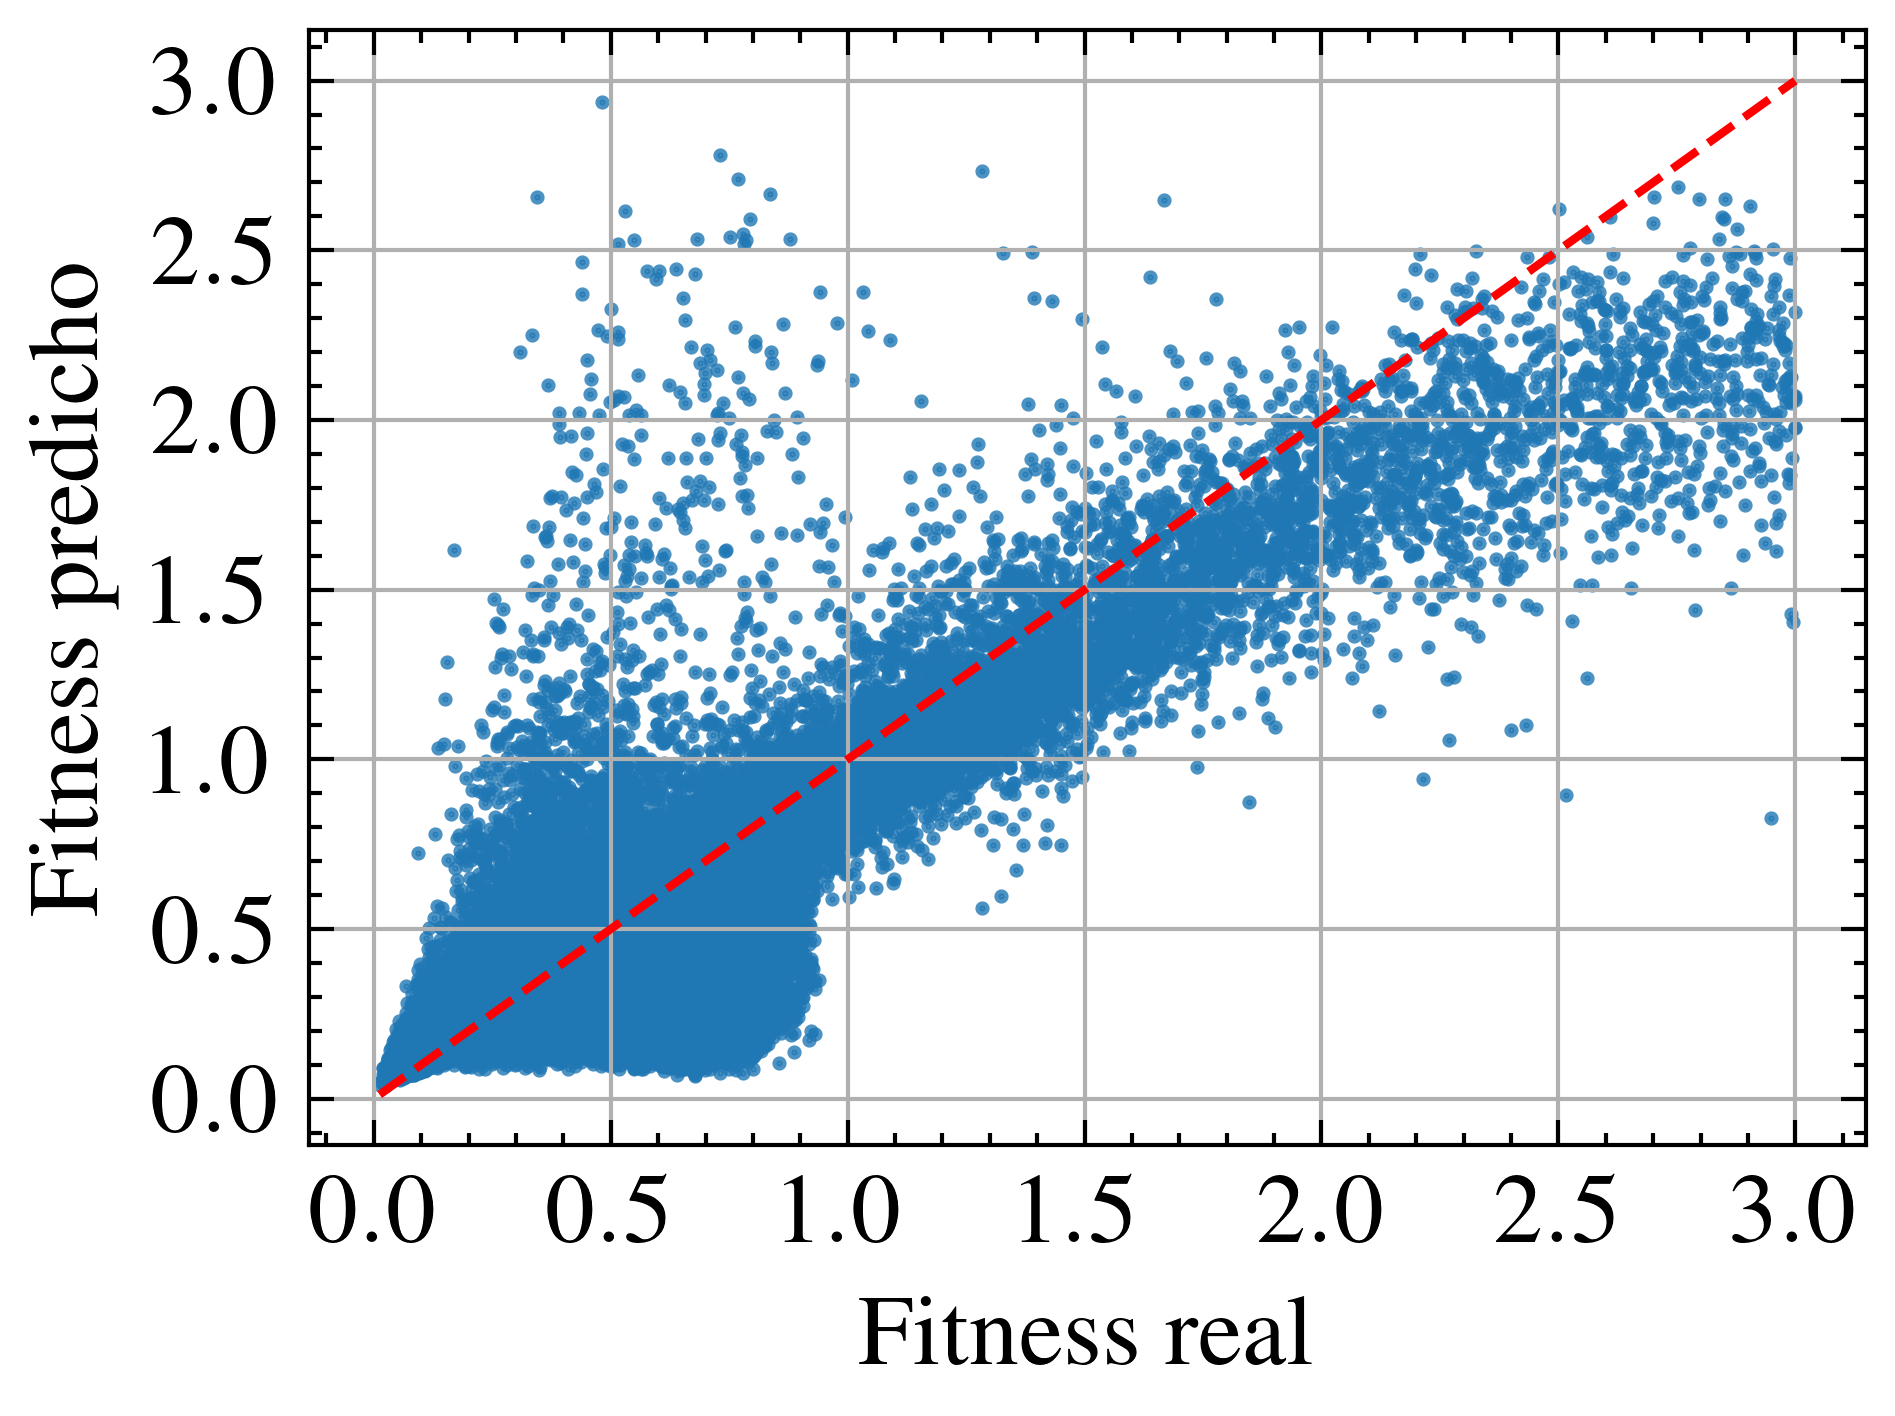

In [66]:
# 5. Visualización: real vs predicho
plt.style.use(["science", "ieee"])  # activás scienceplots
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.tab10.colors)  # ciclo estándar matplotlib

# ---------------------------
fig, ax = plt.subplots()
ax.scatter(y_test_exp3, y_pred_exp3, alpha=0.8, s=0.5)
ax.plot([y_test_exp3.min(), y_test_exp3.max()],
         [y_test_exp3.min(), y_test_exp3.max()],
         'r--')
ax.set_xlabel("Fitness real", fontsize=12)
ax.set_ylabel("Fitness predicho", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.grid()
fig.tight_layout()
fig.savefig("XGBoost_test_exp3.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [87]:
# ---------------------------
# 6. Usar surrogate para explorar
# ---------------------------
# Rango de parámetros según tu dataframe
param_ranges = {
    "D": (df_exp3["D"].min(), df_exp3["D"].max()),
    "A": (df_exp3["A"].min(), df_exp3["A"].max()),
    "B": (df_exp3["B"].min(), df_exp3["B"].max()),
    "beta_1": (df_exp3["beta_1"].min(), df_exp3["beta_1"].max()),
    "beta_2": (df_exp3["beta_2"].min(), df_exp3["beta_2"].max()),
    "beta_3": (df_exp3["beta_3"].min(), df_exp3["beta_3"].max()),
    "beta_4": (df_exp3["beta_4"].min(), df_exp3["beta_4"].max()),
    "beta_5": (df_exp3["beta_5"].min(), df_exp3["beta_5"].max()),
    "gamma_1": (df_exp3["gamma_1"].min(), df_exp3["gamma_1"].max()),
    "gamma_2": (df_exp3["gamma_2"].min(), df_exp3["gamma_2"].max()),
    "gamma_3": (df_exp3["gamma_3"].min(), df_exp3["gamma_3"].max()),
    "gamma_4": (df_exp3["gamma_4"].min(), df_exp3["gamma_4"].max()),
    "gamma_5": (df_exp3["gamma_5"].min(), df_exp3["gamma_5"].max())
}

# Configuración de la búsqueda
N_total = int(1e8)       # total de candidatos a probar (200 millones)
batch_size = int(1e6)    # tamaño del batch (1 millón)
n_batches = N_total // batch_size

k = 20  # top-k por batch
mejores_globales = []

for i in range(n_batches):
    print(f"Batch {i+1}/{n_batches}")

    # Generar candidatos aleatorios dentro de los rangos
    candidatos = np.column_stack([
        np.random.uniform(low, high, batch_size)
        for (low, high) in param_ranges.values()
    ])

    # Predecir fitness con el surrogate model
    preds = model_exp3.predict(candidatos)

    # Obtener los mejores índices (menor fitness = mejor)
    top_idx = np.argsort(preds)[:k]

    # Guardar pares (parámetros, fitness)
    for idx in top_idx:
        mejores_globales.append((candidatos[idx], preds[idx]))

# Convertir a array y seleccionar los mejores globales
mejores_globales = sorted(mejores_globales, key=lambda x: x[1])[:200]

# Separar parámetros y fitness
candidatos_finales = np.array([x[0] for x in mejores_globales])
fitness_finales = np.array([x[1] for x in mejores_globales])

print("Top candidatos encontrados:")
for i, (params, fit) in enumerate(zip(candidatos_finales, fitness_finales), 1):
    print(f"{i}: {params}, fitness={fit}")

Batch 1/100
Batch 2/100
Batch 3/100
Batch 4/100
Batch 5/100
Batch 6/100
Batch 7/100
Batch 8/100
Batch 9/100
Batch 10/100
Batch 11/100
Batch 12/100
Batch 13/100
Batch 14/100
Batch 15/100
Batch 16/100
Batch 17/100
Batch 18/100
Batch 19/100
Batch 20/100
Batch 21/100
Batch 22/100
Batch 23/100
Batch 24/100
Batch 25/100
Batch 26/100
Batch 27/100
Batch 28/100
Batch 29/100
Batch 30/100
Batch 31/100
Batch 32/100
Batch 33/100
Batch 34/100
Batch 35/100
Batch 36/100
Batch 37/100
Batch 38/100
Batch 39/100
Batch 40/100
Batch 41/100
Batch 42/100
Batch 43/100
Batch 44/100
Batch 45/100
Batch 46/100
Batch 47/100
Batch 48/100
Batch 49/100
Batch 50/100
Batch 51/100
Batch 52/100
Batch 53/100
Batch 54/100
Batch 55/100
Batch 56/100
Batch 57/100
Batch 58/100
Batch 59/100
Batch 60/100
Batch 61/100
Batch 62/100
Batch 63/100
Batch 64/100
Batch 65/100
Batch 66/100
Batch 67/100
Batch 68/100
Batch 69/100
Batch 70/100
Batch 71/100
Batch 72/100
Batch 73/100
Batch 74/100
Batch 75/100
Batch 76/100
Batch 77/100
Batch 78

In [88]:
np.savetxt("candidatos_finales_xgboost_exp3.csv", candidatos_finales, delimiter=",", header="D,A,B,beta_1,beta_2,beta_3,beta_4,beta_5,gamma_1,gamma_2,gamma_3,gamma_4,gamma_5", comments='')

In [89]:
from lectura_datos import leer_incendio_referencia
from fitness import aptitud_batch
import cupy as cp

df_candidatos = pd.read_csv("candidatos_finales_xgboost_exp3.csv")
print(df_candidatos)
candidatos = df_candidatos[["D", "A", "B", "beta_1", "beta_2", "beta_3", "beta_4", "beta_5", "gamma_1", "gamma_2", "gamma_3", "gamma_4", "gamma_5"]].values

ruta_incendio_referencia = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/R_referencia_3.npy"
incendio_referencia = leer_incendio_referencia(ruta_incendio_referencia)
celdas_quemadas_referencia = cp.where(incendio_referencia > 0.001, 1, 0)

batch_size = 5

resultados = []

parametros_batch = [
    (
        row["D"], 
        row["A"], 
        row["B"], 
        np.array([row["beta_1"], row["beta_2"], row["beta_3"], row["beta_4"], row["beta_5"]], dtype=np.float32),
        np.array([row["gamma_1"], row["gamma_2"], row["gamma_3"], row["gamma_4"], row["gamma_5"]], dtype=np.float32),
    )
    for _, row in df_candidatos.iterrows()
]

for i in range(0, len(parametros_batch), batch_size):
    print(f'Evaluando batch {i//batch_size + 1} de {len(parametros_batch)//batch_size + 1}')
    candidatos_batch = parametros_batch[i:i+batch_size]
    fitness = aptitud_batch(candidatos_batch, 
                            celdas_quemadas_referencia, 
                            num_steps=500, 
                            ajustar_beta_gamma=True,
                            beta_fijo=None, 
                            gamma_fijo=None,
                            ajustar_ignicion=False,
                            ignicion_fija_x=[1130, 1300, 620],
                            ignicion_fija_y=[290, 150, 280])

    for params, fit in zip(candidatos_batch, fitness):
        D, A, B, beta_params, gamma_params = params
        resultados.append({
            "D": D,
            "A": A,
            "B": B,
            "beta_1": beta_params[0],
            "beta_2": beta_params[1],
            "beta_3": beta_params[2],
            "beta_4": beta_params[3],
            "beta_5": beta_params[4],
            "gamma_1": gamma_params[0],
            "gamma_2": gamma_params[1],
            "gamma_3": gamma_params[2],
            "gamma_4": gamma_params[3],
            "gamma_5": gamma_params[4],
            "fitness": fit,
        })
    
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="fitness", ascending=True)

print(df_resultados)
df_resultados.to_csv("candidatos_finales_validados_exp3.csv", index=False)

                 D             A              B        beta_1        beta_2  \
0    94.2147776151  0.0001259764  13.0380596876  0.8195428821  0.9397492184   
1    90.3303720532  0.0001751247  17.7157921199  0.8577115358  0.9395723900   
2    93.4997807196  0.0001946065  12.2117919150  0.8746702194  0.9367752631   
3    56.0353833809  0.0001774969  20.5745011479  0.6061336959  0.8099774565   
4    65.0315112851  0.0002017967  21.5967030284  0.9606132657  0.9511235196   
..             ...           ...            ...           ...           ...   
195  71.2506134826  0.0002131771  18.3519583371  0.8840804428  0.6662386211   
196  61.4807074990  0.0001061963  21.9299370876  0.8351930801  0.7379496322   
197  64.2579302441  0.0001565227  19.7816970394  0.5178245081  0.8082747860   
198  65.8616523626  0.0001802649  17.0864095355  0.7221828264  0.9310941712   
199  63.5888257521  0.0002301540  21.9917619737  1.0026490841  0.7551892913   

           beta_3        beta_4        beta_5      

In [90]:
# Uso
res = bootstrap_confidence_intervals_df(df_resultados, param_cols=["D", "A", "B", "beta_1", "beta_2", "beta_3", "beta_4", "beta_5", "gamma_1", "gamma_2", "gamma_3", "gamma_4", "gamma_5"])

pd.set_option("display.precision", 10)
best_ci = res["best_params_CI"].copy()

best_ci["uncertainty_%"] = ((best_ci["high"] - best_ci["low"]) / 2) / best_ci["boot_mean"] * 100
print(best_ci.round(7))

      param         low        high   boot_mean  uncertainty_%
0         D  37.4926179  96.9373997  48.1133907     61.7757147
1         A   0.0001178   0.0001895   0.0001415     25.3302296
2         B   8.0238060  23.1834334  18.8331836     40.2471183
3    beta_1   0.6796848   0.9184893   0.8234941     14.4994676
4    beta_2   0.8621433   0.9656405   0.9354043      5.5322148
5    beta_3   0.2670795   0.9039328   0.7371439     43.1973515
6    beta_4   0.8810173   1.4666128   1.3100875     22.3494827
7    beta_5   0.1362354   0.4758635   0.2060020     82.4332032
8   gamma_1   0.5407982   0.7914561   0.7256515     17.2712321
9   gamma_2   0.6869609   0.8256783   0.7310313      9.4877924
10  gamma_3   0.3344128   0.8486428   0.7076519     36.3335431
11  gamma_4   0.0943654   0.8340363   0.4700571     78.6788319
12  gamma_5   0.6830455   0.8708985   0.7347587     12.7833101


### Los resultados fueron malísimos, utilizo Optuna para ajustar los hiperparámetros del modelo

In [3]:
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import glob
import os
import pandas as pd

# ---------------------------
# 1. Cargar datos
# ---------------------------

# Ruta de la carpeta con los CSV
ruta = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/Genetico/resultados/exp3"

# Buscar todos los archivos CSV en la carpeta
archivos_csv = glob.glob(os.path.join(ruta, "*.csv"))

# Leer y concatenar
df = pd.concat((pd.read_csv(archivo) for archivo in archivos_csv), ignore_index=True)

# Features y target
X = df[["D", "A", "B", "beta_1", "beta_2", "beta_3", "beta_4", "beta_5", "gamma_1", "gamma_2", "gamma_3", "gamma_4", "gamma_5"]] 
y = df["fitness"]

# Dividir dataset (si no lo tenés ya separado)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 6000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 100.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "tree_method": "hist",   # GPU si tenés suficiente memoria
        "device": "cuda",
        "random_state": 42,
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

    preds = model.predict(X_valid)
    score = r2_score(y_valid, preds)

    # Queremos maximizar R², pero Optuna minimiza → devolver negativo
    return -score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1)  # podés aumentar n_trials

print("Mejores hiperparámetros:", study.best_params)
print("Mejor score (R²):", -study.best_value)

[I 2025-09-29 21:46:12,789] A new study created in memory with name: no-name-f1f2f1c4-961f-4f45-9d6c-f36afbd71636
c:\Users\becer\miniconda3\envs\pinns\Lib\site-packages\xgboost\core.py:729: UserWarning: [21:48:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-09-29 21:48:10,437] Trial 0 finished with value: -0.7740045040544365 and parameters: {'n_estimators': 953, 'learning_rate': 0.2415391237683062, 'max_depth': 13, 'subsample': 0.6201099942805703, 'colsample_bytree': 0.5497003464557655, 'reg_lambda': 0.02322162761178138, 'reg_alpha': 0.01838

Mejores hiperparámetros: {'n_estimators': 4705, 'learning_rate': 0.028226091141027067, 'max_depth': 10, 'subsample': 0.7526032466184012, 'colsample_bytree': 0.661770739362805, 'reg_lambda': 99.03770555818437, 'reg_alpha': 8.849522288561722}
Mejor score (R²): 0.8721311251436862
